K-Means Clustering Pipeline in Python

These data contain gene expression values from a manuscript authored by The Cancer Genome Atlas (TCGA) Pan-Cancer analysis project investigators.

There are 881 samples (rows) representing five distinct cancer subtypes. Each sample has gene expression values for 20,531 genes (columns). The dataset is available from the UC Irvine Machine Learning Repository.

In [ ]:
import tarfile
import urllib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [ ]:
uci_tcga_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00401/"
archive_name = "TCGA-PANCAN-HiSeq-801x20531.tar.gz"

# Build the url
full_download_url = urllib.parse.urljoin(uci_tcga_url, archive_name)

# Download the file
r = urllib.request.urlretrieve (full_download_url, archive_name)

# Extract the data from the archive
tar = tarfile.open(archive_name, "r:gz")
tar.extractall()
tar.close()

In [ ]:
datafile = "TCGA-PANCAN-HiSeq-801x20531/data.csv"
labels_file = "TCGA-PANCAN-HiSeq-801x20531/labels.csv"

data = np.genfromtxt(
    datafile,
    delimiter=",",
    usecols=range(1, 20532),
    skip_header=1
)

true_label_names = np.genfromtxt(
    labels_file,
    delimiter=",",
    usecols=(1,),
    skip_header=1,
    dtype="str"
)

In [ ]:

data[:5, :3]

array([[0.        , 2.01720929, 3.26552691],
       [0.        , 0.59273209, 1.58842082],
       [0.        , 3.51175898, 4.32719872],
       [0.        , 3.66361787, 4.50764878],
       [0.        , 2.65574107, 2.82154696]])

In [ ]:
true_label_names[:5]

array(['PRAD', 'LUAD', 'PRAD', 'PRAD', 'BRCA'], dtype='<U4')

The labels are strings containing abbreviations of cancer types:

    BRCA: Breast invasive carcinoma
    COAD: Colon adenocarcinoma
    KIRC: Kidney renal clear cell carcinoma
    LUAD: Lung adenocarcinoma
    PRAD: Prostate adenocarcinoma


In [ ]:
label_encoder = LabelEncoder()

true_labels = label_encoder.fit_transform(true_label_names)

true_labels[:5]

array([4, 3, 4, 4, 0])

In [ ]:
label_encoder.classes_


n_clusters = len(label_encoder.classes_)
n_clusters

5

In practical machine learning pipelines, it’s common for the data to undergo multiple sequences of transformations before it feeds into a clustering algorithm. You learned about the importance of one of these transformation steps, feature scaling, earlier in this tutorial. An equally important data transformation technique is dimensionality reduction, which reduces the number of features in the dataset by either removing or combining them.

Principal Component Analysis (PCA) is one of many dimensionality reduction techniques. PCA transforms the input data by projecting it into a lower number of dimensions called components. The components capture the variability of the input data through a linear combination of the input data’s features.

our gene expression data aren’t in the optimal format for the KMeans class, so you’ll need to build a preprocessing pipeline. The pipeline will implement an alternative to the StandardScaler class called MinMaxScaler for feature scaling. You use MinMaxScaler when you do not assume that the shape of all your features follows a normal distribution.

The next step in your preprocessing pipeline will implement the PCA class to perform dimensionality reduction:

In [ ]:
preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=2, random_state=42)),
    ]
)

In [ ]:
clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=n_clusters,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,
           ),
       ),
   ]
)

In [ ]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

In [ ]:
pipe.fit(data)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=5, n_init=50,
                                         random_state=42))]))])

Evaluate the performance by calculating the silhouette coefficient:



In [ ]:
preprocessed_data = pipe["preprocessor"].transform(data)

predicted_labels = pipe["clusterer"]["kmeans"].labels_

silhouette_score(preprocessed_data, predicted_labels)

np.float64(0.5118775528450302)

Calculate ARI, too, since the ground truth cluster labels are available:

In [ ]:
adjusted_rand_score(true_labels, predicted_labels)

0.722276752060253

The scale for each of these clustering performance metrics ranges from -1 to 1. A silhouette coefficient of 0 indicates that clusters are significantly overlapping one another, and a silhouette coefficient of 1 indicates clusters are well-separated. An ARI score of 0 indicates that cluster labels are randomly assigned, and an ARI score of 1 means that the true labels and predicted labels form identical clusters.

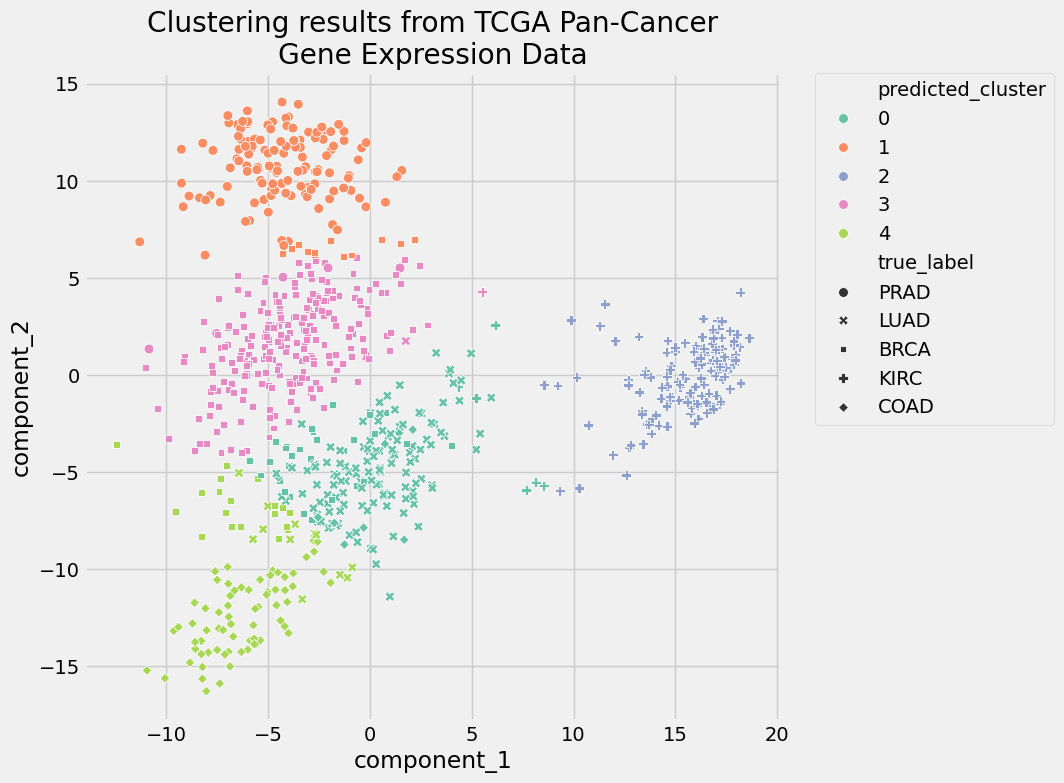

In [ ]:
pcadf = pd.DataFrame(
    pipe["preprocessor"].transform(data),
    columns=["component_1", "component_2"],
)

pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf["true_label"] = label_encoder.inverse_transform(true_labels)

# Assuming you have pcadf, label_encoder, and true_labels defined earlier

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    x="component_1",  # Use x= for x-axis column
    y="component_2",  # Use y= for y-axis column
    s=50,
    data=pcadf,
    hue="predicted_cluster",
    style="true_label",
    palette="Set2",
)

scat.set_title(
    "Clustering results from TCGA Pan-Cancer\nGene Expression Data"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

In [ ]:
# Empty lists to hold evaluation metrics
silhouette_scores = []
ari_scores = []
for n in range(2, 11):
    # This set the number of components for pca,
    # but leaves other steps unchanged
    pipe["preprocessor"]["pca"].n_components = n
    pipe.fit(data)

    silhouette_coef = silhouette_score(
        pipe["preprocessor"].transform(data),
        pipe["clusterer"]["kmeans"].labels_,
    )
    ari = adjusted_rand_score(
        true_labels,
        pipe["clusterer"]["kmeans"].labels_,
    )

    # Add metrics to their lists
    silhouette_scores.append(silhouette_coef)
    ari_scores.append(ari)

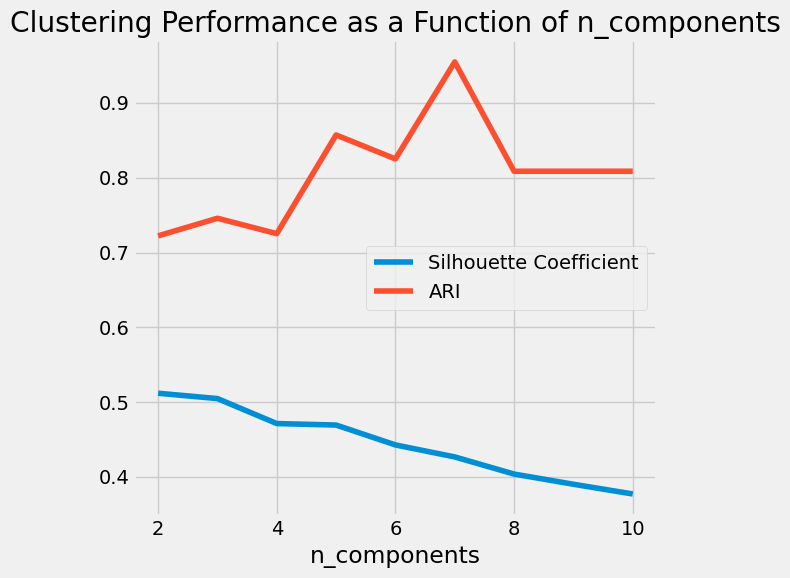

In [ ]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(6, 6))
plt.plot(
    range(2, 11),
    silhouette_scores,
    c="#008fd5",
    label="Silhouette Coefficient",
)
plt.plot(range(2, 11), ari_scores, c="#fc4f30", label="ARI")

plt.xlabel("n_components")
plt.legend()
plt.title("Clustering Performance as a Function of n_components")
plt.tight_layout()
plt.show()